Basic import and data reading

In [272]:
import matplotlib.pyplot as plt
import pandas
import statistics
import numpy 
import math
import scipy
import statistics

pandas.options.display.float_format = '{:20,.4f}'.format
numpy.set_printoptions(formatter={'float_kind': "{:.4f}".format})
plt.style.use('dark_background')

In [273]:
AppStore = pandas.read_csv('appleAppData.csv') 

PlayStore = pandas.read_csv('Google-Playstore.csv',
                            usecols=["App Name","App Id","Category","Rating","Rating Count","Minimum Installs","Maximum Installs","Free","Price","Size","Developer Id","Released","Last Updated","Content Rating","Ad Supported","In App Purchases","Editors Choice","Scraped Time"],
                            dtype={'Installs':'category', 'Category':'category','Content Rating':'category',
                            'Rating':'float16', 'Rating Count':'float32', 'Price':'float16',})

Data formatting

In [274]:
AppStore['Primary_Genre'] = AppStore['Primary_Genre'].astype('category')
AppStore['Content_Rating'] = AppStore['Content_Rating'].astype('category')

AppStore['Released'] = pandas.to_datetime(AppStore['Released'], format='%Y-%m-%dT%H:%M:%S')
AppStore['Updated'] = pandas.to_datetime(AppStore['Updated'], format='%Y-%m-%dT%H:%M:%S')

AppStore.drop(columns=['Current_Version_Score','Current_Version_Reviews','Required_IOS_Version','Developer_Website', 'Developer_Url','Currency'], inplace=True)
AppStore.drop(columns=['Version'], inplace=True)

In [275]:
PlayStore['Released'] = pandas.to_datetime(PlayStore['Released'], format='%b %d, %Y')
PlayStore['Last Updated'] = pandas.to_datetime(PlayStore['Last Updated'], format='%b %d, %Y')
PlayStore['Scraped Time'] = pandas.to_datetime(PlayStore['Scraped Time'], format='%Y-%m-%d %H:%M:%S')

def size_to_kilobytes(a):
    try:
        if math.isnan(a) or a=='Varies with device': return
    except:
        if "G" in a: 
            if ',' in a: a = a.replace(',' , '')
            return float(a[:-1])*1_000_000
        elif "M" in a: 
            if ',' in a: a = a.replace(',' , '')
            return float(a[:-1])*1_000
        elif "k" in a: 
            if ',' in a: a = a.replace(',' , '')
            return float(a[:-1]) 

PlayStore['Size kilobytes'] = PlayStore['Size'].apply(lambda x: size_to_kilobytes(x))
PlayStore = PlayStore[PlayStore['Maximum Installs'] > 0]
PlayStore.loc[PlayStore['Price']==0.0, 'Free'] = True

Missing data handling

In [276]:
AppStore['isMissingPrice'] = False
AppStore.loc[AppStore['Price'].isnull(), 'isMissingPrice'] = True
AppStore[AppStore['Price'].isnull()].head()
# do not run this code snippet more than ONE time!

AppStore.loc[AppStore['Price'].isnull(), 'Price'] = 0
AppStore.loc[AppStore['Price'].isnull(), 'Free'] = True
AppStore.loc[AppStore['Released'].isnull(), 'Free'] = True
AppStore.loc[AppStore['Released'].isnull(), 'Released'] = AppStore.loc[AppStore['Released'].isnull(), 'Updated']
AppStore['Size_Megabytes'] = AppStore['Size_Bytes']/1_000_000

In [277]:
def min_installs_imputation(num):
    arr = [0, 1.0, 5.0, 10.0, 50.0, 100.0,500.0,1000.0,5000.0, 10000.0,50000.0,100000.0,500000.0, 1000000.0,5000000.0,10000000.0,50000000.0,100000000.0,500000000.0,1000000000.0,5000000000.0,10000000000.0]
    for i in range(len(arr)):
        if arr[i]>num: return arr[i-1]
    return

PlayStore.loc[PlayStore['Minimum Installs'].isnull(), 'Minimum Installs'] = PlayStore.loc[PlayStore['Minimum Installs'].isnull(), 'Maximum Installs'].apply(min_installs_imputation)
PlayStore.loc[PlayStore['Developer Id'].isnull(), 'Developer Id'] = 'Unknown'
PlayStore.loc[PlayStore['Rating Count'].isnull(), 'Rating Count'] = 0
PlayStore.loc[PlayStore['Rating'].isnull(), 'Rating'] = 0
PlayStore.loc[PlayStore['Released'].isna(), 'Released'] = PlayStore.loc[PlayStore['Released'].isna(), 'Last Updated']

Data transforamtion before modelling

In [278]:
AppStore['Size_Bytes_log'] = AppStore['Size_Bytes'].apply(lambda x: numpy.log(x))
AppStore['Size_Megabytes_log'] = AppStore['Size_Megabytes'].apply(lambda x: numpy.log(x))
AppStore['Reviews_log'] = AppStore['Reviews'].apply(lambda x: 0 if x==0 else numpy.log(x))

In [279]:
PlayStore['Rating Count log'] = PlayStore['Rating Count'].apply(lambda x: None if x==0 else numpy.log(x))
PlayStore['Maximum Installs log'] = PlayStore['Maximum Installs'].apply(lambda x: numpy.log(x))
PlayStore['Minimum Installs log'] = PlayStore['Minimum Installs'].apply(lambda x: numpy.log(x))
PlayStore['Size kilobytes log'] = PlayStore['Size kilobytes'].apply(lambda x: numpy.log(x))

game_categories = ['Action','Adventure','Arcade','Board','Card','Casino','Casual','Educational','Music','Puzzle','Racing','Role Playing','Simulation','Sports','Strategy', 'Trivia', 'Word']
def in_game_cat(cat):
    if cat in game_categories: return 'Game'
    else: return cat

PlayStore['Category_2'] = PlayStore['Category'].apply(in_game_cat)

del game_categories

Data standardization

In [280]:
AppStore.sort_values('Reviews', ascending=False, inplace=True)
AppStore['Reviews_rank'] = AppStore['Reviews'].rank(method='max').apply(lambda x: x-684_319)
AppStore.sort_index(inplace=True)

In [281]:
PlayStore.sort_values('Rating Count', ascending=False, inplace=True)
PlayStore['Maximum Installs rank'] = PlayStore['Maximum Installs'].rank(method='max').apply(lambda x: x-15).astype('int64')
PlayStore['Rating Count rank'] = PlayStore['Rating Count'].rank(method='max').apply(lambda x: x-1_071_198)
PlayStore.sort_index(inplace=True)

In [282]:
game_categories = ['Game', 'Education', 'Music & Audio', 'Tools', 'Business',
       'Entertainment', 'Lifestyle', 'Books & Reference', 'Personalization',
       'Health & Fitness', 'Productivity', 'Shopping', 'Food & Drink',
       'Travel & Local']
PlayStore['Category_3'] = PlayStore['Category_2'].apply(lambda x: x if x in game_categories else 'Other')
del game_categories

In [283]:
PlayStore['isRated'] = 0
PlayStore.loc[PlayStore['Rating']>0, 'isRated'] = 1

## Devs and their stats

In [284]:
dev_count = PlayStore[['App Id', 'Developer Id']].groupby('Developer Id').count()
PlayStore['Developer Total Count'] = PlayStore['Developer Id'].apply(lambda x: dev_count.loc[x, 'App Id'])
del dev_count

In [285]:
dev_max_install = PlayStore[['Developer Id','Maximum Installs']].groupby('Developer Id').sum()
PlayStore['Developer Total Installs'] = PlayStore['Developer Id'].apply(lambda x: dev_max_install.loc[x, 'Maximum Installs'])
PlayStore['Developer Total Installs log'] = PlayStore['Developer Total Installs'].apply(lambda x: numpy.log(x))
del dev_max_install

In [286]:
stamp = PlayStore['Scraped Time'][0]
dev_on_market = PlayStore[['Developer Id','Released']].groupby('Developer Id').min()
dev_on_market['On_market'] = dev_on_market['Released'].apply(lambda x: ((stamp-x)/numpy.timedelta64(1, 'M')))
PlayStore['Developer on market']=PlayStore['Developer Id'].apply(lambda x: dev_on_market.loc[x, 'On_market'])
del stamp, dev_on_market

dev_current_count = PlayStore.groupby(['Developer Id', 'Released']).count()['App Id']

c1 = dev_current_count.to_numpy()
c2 = dev_current_count.index.to_numpy()

r = numpy.empty_like(c1)
this_dev = c2[0][0]
this_count = c1[0]
r[0] = c1[0]
for i in range(1,len(c1)):
    if this_dev==c2[i][0]:
        this_count += c1[i]
        r[i] = this_count
    else:
        this_dev=c2[i][0]
        this_count=c1[i]
        r[i] = this_count

print(len(r))
df = pandas.DataFrame({'count':c1,'current_count':r}, index=c2)

## PlayStore - Split

In [287]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy.builtins import Q

In [288]:
from sklearn.model_selection import train_test_split
train_play, vt_play = train_test_split(PlayStore, test_size=0.6)
valid_play, test_play = train_test_split(vt_play, test_size=0.5)
main_play = pandas.concat([train_play, valid_play])
del vt_play

from sklearn.model_selection import train_test_split
train_play, vt_play = train_test_split(PlayStore.loc[(PlayStore['Rating']>0)&(PlayStore['Rating']<5), \
    ['App Id', 'Rating', 'Rating Count','Rating Count log', 'Rating Count rank', 'Category_2',\
     'Maximum Installs', 'Maximum Installs log', 'Maximum Installs rank',\
     'Free', 'Price', 'Content Rating','Ad Supported','In App Purchases',\
     'Editors Choice','Size kilobytes log', 'Category_3']], test_size=0.6)
valid_play, test_play = train_test_split(vt_play, test_size=0.5)
del vt_play

### Linear Regression

### Multiple models

In [289]:
def ols_model_results_cols(cols):
    columns = ['Variable','Params','r-squared','r-adj','AIC','BIC','log-likelihood']
    model_results = pandas.DataFrame(columns=columns)

    for col in cols:
        formula = 'Q("Rating Count log")~'
        cat = ['Category','Category_2','Category_3','Content Rating']
        if col in cat: formula += f'C({col})'
        else: formula += f'Q("{col}")'
        res = smf.ols(formula=formula, data=train_play).fit()
        result = [col, res.params[1], res.rsquared, res.rsquared_adj, res.aic, res.bic, res.llf]
        model_results = model_results.append(dict(zip(model_results.columns, result)), ignore_index=True)

    return model_results

#m1 = ols_model_results_cols([['Maximum Installs rank', 'Size kilobytes log'],['Maximum Installs log','Category_3'], \
#    ['Maximum Installs rank', 'Size kilobytes log'], ['Maximum Installs rank','Category_3'], \
#    ['Category','Size kilobytes log'], ['Category','Editors Choice']])

models = ols_model_results_cols(['Minimum Installs', 'Maximum Installs',
       'Price', 'Size kilobytes', 'Rating Count log', 'Maximum Installs log',
       'Minimum Installs log', 'Size kilobytes log', 'Maximum Installs rank',
       'Rating Count rank', 'Developer Total Count',
       'Developer Total Installs', 'Developer Total Installs log',
       'Developer on market', 'Category','Category_2','Category_3'])
       
models.sort_values('AIC')

Variable               Params            r-squared  \
4               Rating Count log               1.0000               1.0000   
9              Rating Count rank               0.0000               0.8645   
5           Maximum Installs log               0.7290               0.7543   
6           Minimum Installs log               0.7073               0.7317   
8          Maximum Installs rank               0.0000               0.5712   
12  Developer Total Installs log               0.3401               0.2780   
3                 Size kilobytes               0.0000               0.0257   
7             Size kilobytes log               0.2541               0.0199   
13           Developer on market               0.0158               0.0572   
14                      Category              -0.1708               0.0494   
15                    Category_2              -0.0572               0.0347   
16                    Category_3              -0.6533               0.0287   
1               Maximum Installs               0.0000               0.0055   
0               Minimum Installs               0.0000               0.0049   
10         Developer Total Count              -0.0005               0.0038   
11      Developer Total Installs               0.0000               0.0023   
2                          Price               0.0027               0.0000   

                  r-adj                  AIC                  BIC  \
4                1.0000     -27,929,416.4327     -27,929,394.2225   
9                0.8645       1,155,132.0959       1,155,154.3061   
5                0.7543       1,447,563.4578       1,447,585.6680   
6                0.7317       1,490,871.2507       1,490,893.4609   
8                0.5712       1,721,262.3702       1,721,284.5804   
12               0.2780       1,977,316.8220       1,977,339.0322   
3                0.0257       2,037,924.8580       2,037,947.0021   
7                0.0199       2,040,754.2307       2,040,776.3748   
13               0.0572       2,108,445.3947       2,108,467.6049   
14               0.0494       2,112,572.3614       2,113,105.4061   
15               0.0346       2,120,111.7119       2,120,467.0750   
16               0.0287       2,123,126.1608       2,123,292.7372   
1                0.0055       2,134,679.6558       2,134,701.8660   
0                0.0049       2,134,974.6425       2,134,996.8527   
10               0.0038       2,135,517.4335       2,135,539.6437   
11               0.0023       2,136,249.2109       2,136,271.4211   
2                0.0000       2,137,399.2430       2,137,421.4532   

         log-likelihood  
4       13,964,710.2163  
9         -577,564.0480  
5         -723,779.7289  
6         -745,433.6254  
8         -860,629.1851  
12        -988,656.4110  
3       -1,018,960.4290  
7       -1,020,375.1154  
13      -1,054,220.6974  
14      -1,056,238.1807  
15      -1,060,023.8559  
16      -1,061,548.0804  
1       -1,067,337.8279  
0       -1,067,485.3213  
10      -1,067,756.7168  
11      -1,068,122.6055  
2       -1,068,697.6215

In [290]:
import itertools
def ols_model_results(n_cols):

    columns=[]
    for x in range(n_cols):
        columns.append(f'var_{x+1}')
    #for x in range(n_cols):
    #    columns.append(f'var_{x+1}_coef')
    columns.extend(['r-squared','r-adj','AIC','BIC','log-likelihood'])
    model_results = pandas.DataFrame(columns=columns)

    categories=['Category','Category_2','Category_3','Content Rating']
    iter = [f'C({x})' if x in categories else f'Q("{x}")' for x in PlayStore.columns.to_list()]
    iterables = [iter]*n_cols
    
    for t in itertools.product(*iterables):
        flag = False
        for i in range(len(t)):
            for i1 in range(len(t)):
                if i != i1:
                    if t[i] == t[i1]:
                        flag = True
        if(flag): continue
        formula = 'Rating~'
        formula = formula + '+'.join(t)

        try:
            res = smf.ols(formula=formula, data=train_play).fit()
            result = [x for x in t]
            result.extend([res.rsquared, res.rsquared_adj, res.aic, res.bic, res.llf])
            model_results = model_results.append(dict(zip(columns, result)), ignore_index=True)
        except:
            continue
    
    return model_results

In [291]:
def ols_model_results_cols(cols):
    columns = ['Variables','Params','r-squared','r-adj','AIC','BIC','log-likelihood']
    model_results = pandas.DataFrame(columns=columns)

    for col in cols:
        cat = ['Category','Category_2','Category_3','Content Rating']
        if col in cat:
            formula = f'Rating ~ C({col})'
        else: formula = f'Rating ~ Q("{col}")'
        res = smf.ols(formula=formula, data=train_play).fit()
        result = [col, res.params[1], res.rsquared, res.rsquared_adj, res.aic, res.bic, res.llf]
        model_results = model_results.append(dict(zip(model_results.columns, result)), ignore_index=True)

    return model_results


m1 = ols_model_results_cols(['Rating Count', 'Minimum Installs', 'Maximum Installs',
       'Price', 'Size kilobytes', 'Rating Count log', 'Maximum Installs log',
       'Minimum Installs log', 'Size kilobytes log', 'Maximum Installs rank',
       'Rating Count rank', 'Developer Total Count',
       'Developer Total Installs', 'Developer Total Installs log',
       'Developer on market', 'Category','Category_2'])

### MODEL 1

In [292]:
res = smf.ols('Rating ~ Q("Maximum Installs rank")', train_play).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                 7.879e+05
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:47:49   Log-Likelihood:            -1.7076e+06
No. Observations:              920542   AIC:                         3.415e+06
Df Residuals:                  920540   BIC:                         3.415e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [293]:
res = smf.ols('Rating ~ Q("Maximum Installs log")', train_play).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                 6.540e+05
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:47:50   Log-Likelihood:            -1.7452e+06
No. Observations:              920542   AIC:                         3.490e+06
Df Residuals:                  920540   BIC:                         3.490e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

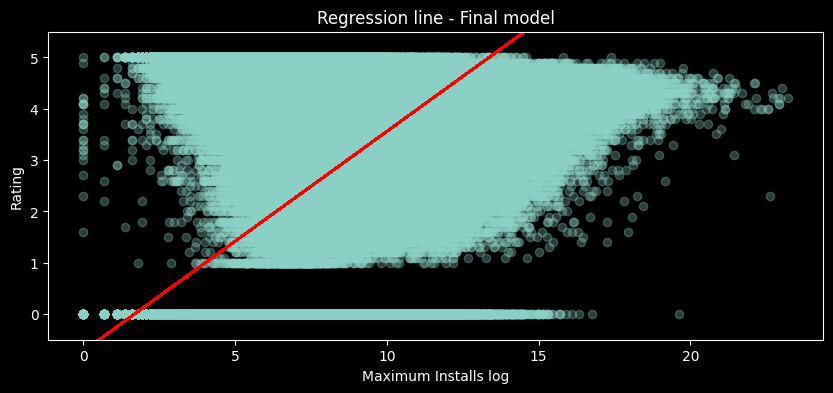

In [294]:
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(main_play['Maximum Installs log'],main_play['Rating'], alpha=0.3)
ax.plot(main_play['Maximum Installs log'], 0.4280*main_play['Maximum Installs log']-0.7212, color='red')
ax.set_ylim((-0.5,5.5))
ax.set_title('Regression line - Final model')
ax.set_xlabel('Maximum Installs log')
ax.set_ylabel('Rating')
plt.show()

In [295]:
# R-squared
1 - numpy.sum((res.predict(valid_play['Maximum Installs log']).to_numpy() - valid_play['Rating'])**2) / numpy.sum((valid_play['Rating'].to_numpy(dtype='float64') - numpy.mean(valid_play['Rating'].to_numpy(dtype='float64')))**2)

0.4153293255891688

In [296]:
# R-squared adjusted
1 -   numpy.sum((res.predict(valid_play['Maximum Installs log']).to_numpy() - valid_play['Rating'])**2) / numpy.sum((valid_play['Rating'].to_numpy(dtype='float64') - numpy.mean(valid_play['Rating'].to_numpy(dtype='float64')))**2)

0.4153293255891688

Test set and assessing

In [297]:
final_model = smf.ols('Rating ~ Q("Maximum Installs log")', main_play).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                 1.144e+06
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:47:56   Log-Likelihood:            -3.0538e+06
No. Observations:             1610948   AIC:                         6.108e+06
Df Residuals:                 1610946   BIC:                         6.108e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### MODEL 2

In [298]:
train_play.columns

Index(['App Name', 'App Id', 'Category', 'Rating', 'Rating Count',
       'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Size',
       'Developer Id', 'Released', 'Last Updated', 'Content Rating',
       'Ad Supported', 'In App Purchases', 'Editors Choice', 'Scraped Time',
       'Size kilobytes', 'Rating Count log', 'Maximum Installs log',
       'Minimum Installs log', 'Size kilobytes log', 'Category_2',
       'Maximum Installs rank', 'Rating Count rank', 'Category_3', 'isRated',
       'Developer Total Count', 'Developer Total Installs',
       'Developer Total Installs log', 'Developer on market'],
      dtype='object')

In [299]:
res = smf.ols('Rating ~ Q("Maximum Installs rank") + Free', main_play).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                 6.953e+05
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:47:57   Log-Likelihood:            -2.9849e+06
No. Observations:             1610948   AIC:                         5.970e+06
Df Residuals:                 1610945   BIC:                         5.970e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [300]:
sm.graphics.plot_partregress_grid(res, fig=fig)
fig.tight_layout(pad=1.0)
plt.show()
plt.style.use('dark_background')

eval_env: 1
eval_env: 1
eval_env: 1


In [301]:
# R-squared
1 - numpy.sum((res.predict(valid_play[['Maximum Installs rank','Free']]).to_numpy() - valid_play['Rating'])**2) / numpy.sum((valid_play['Rating'].to_numpy(dtype='float64') - numpy.mean(valid_play['Rating'].to_numpy(dtype='float64')))**2)

0.4634570098089825

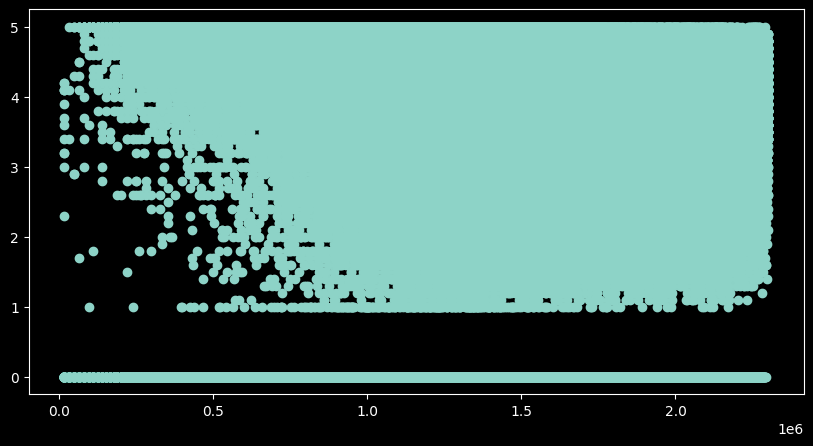

In [302]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(train_play['Maximum Installs rank'], train_play['Rating'])
plt.show()

### MODEL 3

In [303]:
res = smf.ols('Rating ~ Q("Maximum Installs rank") + C(Category_2)', train_play).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                 2.505e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:48:10   Log-Likelihood:            -1.7039e+06
No. Observations:              920542   AIC:                         3.408e+06
Df Residuals:                  920509   BIC:                         3.408e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [304]:
# R-squared
1 - numpy.sum((res.predict(valid_play[['Maximum Installs rank','Category_2']]).to_numpy() - valid_play['Rating'])**2) / numpy.sum((valid_play['Rating'].to_numpy(dtype='float64') - numpy.mean(valid_play['Rating'].to_numpy(dtype='float64')))**2)

0.465801015553189

In [305]:
res = smf.ols('Rating ~ Q("Maximum Installs rank") + C(Category_2)', main_play).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                 4.386e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:48:27   Log-Likelihood:            -2.9814e+06
No. Observations:             1610948   AIC:                         5.963e+06
Df Residuals:                 1610915   BIC:                         5.963e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [306]:
train_play.describe().columns

Index(['Rating', 'Rating Count', 'Minimum Installs', 'Maximum Installs',
       'Price', 'Size kilobytes', 'Rating Count log', 'Maximum Installs log',
       'Minimum Installs log', 'Size kilobytes log', 'Maximum Installs rank',
       'Rating Count rank', 'isRated', 'Developer Total Count',
       'Developer Total Installs', 'Developer Total Installs log',
       'Developer on market'],
      dtype='object')

### MODEL full

In [307]:
cols = ['Minimum Installs', 'Maximum Installs',
       'Price', 'Size kilobytes', 'Rating Count log', 'Maximum Installs log',
       'Minimum Installs log', 'Size kilobytes log', 'Maximum Installs rank',
       'Rating Count rank', 'Developer Total Count',
       'Developer Total Installs', 'Developer Total Installs log',
       'Developer on market']

formula = 'Rating ~ Q("' + '") + Q("'.join(cols) + '")'

res = smf.ols(formula, train_play).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     6424.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:48:31   Log-Likelihood:            -4.5755e+05
No. Observations:              475471   AIC:                         9.151e+05
Df Residuals:                  475456   BIC:                         9.153e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

### MODEL ?

In [308]:
res = smf.ols('Q("Rating Count rank") ~ Q("Maximum Installs log") + Q("Developer Total Installs log") * Q("Developer on market")', train_play).fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Q("Rating Count rank")   R-squared:                       0.725
Model:                                OLS   Adj. R-squared:                  0.725
Method:                     Least Squares   F-statistic:                 6.057e+05
Date:                    Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                            21:48:32   Log-Likelihood:            -1.2588e+07
No. Observations:                  920542   AIC:                         2.518e+07
Df Residuals:                      920537   BIC:                         2.518e+07
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

### Model - Split with no extreme values

In [309]:
#from sklearn.model_selection import train_test_split
#train_play, vt_play = train_test_split(PlayStore.loc[(PlayStore['Rating']>0)&(PlayStore['Rating']<5)], test_size=0.6)
#valid_play, test_play = train_test_split(vt_play, test_size=0.5)
#del vt_play

### Logistic Regression

1 varaible models

In [310]:
import statsmodels.formula.api as smf

In [311]:
from sklearn.model_selection import train_test_split
train_play, vt_play = train_test_split(PlayStore, test_size=0.6)
valid_play, test_play = train_test_split(vt_play, test_size=0.5)
main_play = pandas.concat([train_play, valid_play])
del vt_play

In [312]:
res = smf.logit('isRated ~ Q("Developer Total Count")', \
    data=train_play).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.682644
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                isRated   No. Observations:               920542
Model:                          Logit   Df Residuals:                   920540
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                 0.01162
Time:                        21:48:44   Log-Likelihood:            -6.2840e+05
converged:                       True   LL-Null:                   -6.3579e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2102      0.002     96.049      0.000      

In [313]:
cols_test = ['Minimum Installs', 'Maximum Installs',
       'Price', 'Size kilobytes', 'Maximum Installs log',
       'Size kilobytes log', 'Maximum Installs rank','Developer Total Count',
       'Developer Total Installs', 'Developer Total Installs log',
       'Developer on market', 'Category_2', 'Category_3']

logit_model_results = pandas.DataFrame(columns=['variable','coef', 'pseudo r-sqr','log-likelihood','AIC','BIC','LLR p-value'])

for col in cols_test:
       if col in ['Category_2', 'Category_3']: res = smf.logit(f'isRated ~ C({col})', data=train_play).fit()
       else: res = smf.logit(f'isRated ~ Q("{col}")', data=train_play).fit()
       result = [col, res.params[1], res.prsquared, res.llf, res.aic, res.bic, res.llr_pvalue]
       logit_model_results = logit_model_results.append(dict(zip(['variable','coef', 'pseudo r-sqr','log-likelihood','AIC','BIC','LLR p-value'], result)), ignore_index=True)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 15
Optimization terminated successfully.
         Current function value: inf
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.690669
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.347963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.347051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682644
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.620724
         Itera

In [314]:
logit_model_results.sort_values('AIC')

variable                 coef         pseudo r-sqr  \
6          Maximum Installs rank               0.0000               0.4975   
4           Maximum Installs log               0.9743               0.4962   
9   Developer Total Installs log               0.2202               0.1013   
3                 Size kilobytes               0.0000               0.0024   
5             Size kilobytes log               0.0939               0.0020   
11                    Category_2               0.1512               0.0278   
12                    Category_3              -0.9228               0.0231   
10           Developer on market               0.0107               0.0191   
7          Developer Total Count              -0.0008               0.0116   
2                          Price              -0.0004               0.0000   
0               Minimum Installs               0.0002                 -inf   
1               Maximum Installs               0.0001                 -inf   
8       Developer Total Installs               0.0000                 -inf   

         log-likelihood                  AIC                  BIC  \
6         -319,474.8006         638,953.6012         638,977.0667   
4         -320,314.2793         640,632.5585         640,656.0240   
9         -571,402.4588       1,142,808.9177       1,142,832.3831   
3         -613,646.8547       1,227,297.7093       1,227,321.1088   
5         -613,886.9752       1,227,777.9503       1,227,801.3499   
11        -618,097.1186       1,236,258.2373       1,236,633.6842   
12        -621,132.8732       1,242,295.7464       1,242,471.7372   
10        -623,676.5809       1,247,357.1617       1,247,380.6272   
7         -628,402.1781       1,256,808.3562       1,256,831.8216   
2         -635,789.7867       1,271,583.5734       1,271,607.0389   
0                  -inf                  inf                  inf   
1                  -inf                  inf                  inf   
8                  -inf                  inf                  inf   

            LLR p-value  
6                0.0000  
4                0.0000  
9                0.0000  
3                0.0000  
5                0.0000  
11               0.0000  
12               0.0000  
10               0.0000  
7                0.0000  
2                0.6809  
0                1.0000  
1                1.0000  
8                1.0000

In [ ]:
#categorical variables are not performing well in our case
res = smf.logit('isRated ~ C("Category_2")', \
    data=train_play).fit()
print(res.summary())

Logit MODEL 2

In [317]:
res = smf.logit('isRated ~ Q("Maximum Installs log") + Q("Developer Total Installs log")',\
       train_play).fit()
print(res.summary())
cross = pandas.crosstab(res.predict(valid_play[['Maximum Installs log','Developer Total Installs log']]).apply(lambda x: 1 if x>=0.5 else 0), valid_play['isRated'], normalize=True)
print(cross)
print('================================================')
print(f'Accuracy = {cross.loc[1,1] + cross.loc[0,0]}')
print(f'Sensitivity = {cross.loc[1,1]/cross.loc[1].sum()}')
print(f'Specificity = {cross.loc[0,0]/cross.loc[0].sum()}') 

Optimization terminated successfully.
         Current function value: 0.341631
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                isRated   No. Observations:               920542
Model:                          Logit   Df Residuals:                   920539
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5054
Time:                        21:50:07   Log-Likelihood:            -3.1449e+05
converged:                       True   LL-Null:                   -6.3579e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -5.6430      0.014   -415

In [318]:
res = smf.logit('isRated ~ Q("Maximum Installs rank") + Q("Developer Total Installs log")',\
       train_play).fit()
print(res.summary())
cross = pandas.crosstab(res.predict(valid_play[['Maximum Installs rank','Developer Total Installs log']]).apply(lambda x: 1 if x>=0.5 else 0), valid_play['isRated'], normalize=True)
print(cross)
print('================================================')
print(f'Accuracy = {cross.loc[1,1] + cross.loc[0,0]}')
print(f'Sensitivity = {cross.loc[1,1]/cross.loc[1].sum()}')
print(f'Specificity = {cross.loc[0,0]/cross.loc[0].sum()}') 

Optimization terminated successfully.
         Current function value: 0.340716
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                isRated   No. Observations:               920542
Model:                          Logit   Df Residuals:                   920539
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5067
Time:                        21:50:10   Log-Likelihood:            -3.1364e+05
converged:                       True   LL-Null:                   -6.3579e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -3.5235      0.011   -334

In [319]:
res = smf.logit('isRated ~ Q("Maximum Installs log") + Q("Developer Total Installs log")',\
       main_play).fit()
print(res.summary())
cross = pandas.crosstab(res.predict(main_play[['Maximum Installs log','Developer Total Installs log']]).apply(lambda x: 1 if x>=0.5 else 0), main_play['isRated'], normalize=True)
print(cross)
print('================================================')
print(f'Accuracy = {cross.loc[1,1] + cross.loc[0,0]}')
print(f'Sensitivity = {cross.loc[1,1]/cross.loc[1].sum()}')
print(f'Specificity = {cross.loc[0,0]/cross.loc[0].sum()}') 

Optimization terminated successfully.
         Current function value: 0.341421
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                isRated   No. Observations:              1610948
Model:                          Logit   Df Residuals:                  1610945
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5057
Time:                        21:50:19   Log-Likelihood:            -5.5001e+05
converged:                       True   LL-Null:                   -1.1127e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -5.6435      0.010   -549

In [320]:
res = smf.logit('isRated ~ Q("Maximum Installs rank") + Q("Developer Total Installs log")',\
       main_play).fit()
print(res.summary())
cross = pandas.crosstab(res.predict(main_play[['Maximum Installs rank','Developer Total Installs log']]).apply(lambda x: 1 if x>=0.5 else 0), main_play['isRated'], normalize=True)
print(cross)
print('================================================')
print(f'Accuracy = {cross.loc[1,1] + cross.loc[0,0]}')
print(f'Sensitivity = {cross.loc[1,1]/cross.loc[1].sum()}')
print(f'Specificity = {cross.loc[0,0]/cross.loc[0].sum()}') 

Optimization terminated successfully.
         Current function value: 0.340463
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                isRated   No. Observations:              1610948
Model:                          Logit   Df Residuals:                  1610945
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5071
Time:                        21:50:29   Log-Likelihood:            -5.4847e+05
converged:                       True   LL-Null:                   -1.1127e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -3.5231      0.008   -443

In [321]:
res = smf.logit('isRated ~ Q("Size kilobytes log") + Q("Ad Supported") + Q("Editors Choice")',\
       train_play).fit()
print(res.summary())

print(pandas.crosstab(res.predict(valid_play[['Size kilobytes log','Ad Supported','Editors Choice']]).apply(lambda x: 1 if x>=0.5 else 0), valid_play['isRated'], normalize=True))

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

## Good models Found

In [ ]:
res = smf.logit('isRated ~ Q("Maximum Installs rank")', data=train_play).fit()
print(res.summary())
print(pandas.crosstab(res.predict(valid_play['Maximum Installs rank']).apply(lambda x: 1 if x>=0.5 else 0), valid_play['isRated'], normalize=True))

In [ ]:
res = smf.logit('isRated ~ Q("Maximum Installs rank")', data=main_play).fit()
print(res.summary())
print(pandas.crosstab(res.predict(main_play['Maximum Installs rank']).apply(lambda x: 1 if x>=0.5 else 0), main_play['isRated'], normalize=True))

In [ ]:
res = smf.logit('isRated ~ Q("Maximum Installs log")', data=train_play).fit()
print(res.summary())
print(pandas.crosstab(res.predict(valid_play['Maximum Installs log']).apply(lambda x: 1 if x>=0.5 else 0), valid_play['isRated'], normalize=True))

In [ ]:
res = smf.logit('isRated ~ Q("Maximum Installs log")', data=main_play).fit()
print(res.summary())
print(pandas.crosstab(res.predict(main_play['Maximum Installs log']).apply(lambda x: 1 if x>=0.5 else 0), main_play['isRated'], normalize=True))

2 varible inputs

In [ ]:
res = smf.ols('Q("Rating Count rank") ~ Q("Maximum Installs log") + Q("Developer Total Installs log") * Q("Developer on market")', train_play).fit()
print(res.summary())

In [ ]:
v_pred = res.predict(valid_play[['Maximum Installs log','Developer Total Installs log','Developer on market']])
v_pred

In [ ]:
# R-squared performance on Validation set
1- numpy.sum((valid_play['Rating Count rank'].to_numpy() - v_pred.to_numpy())**2) / numpy.sum(valid_play['Rating Count rank'].to_numpy()**2)

Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from patsy import dmatrix
from patsy import dmatrices

In [ ]:
# creating clean dataset with non-extreme values
from sklearn.model_selection import train_test_split
train_play, vt_play = train_test_split(PlayStore.loc[(PlayStore['Rating']>0)&(PlayStore['Rating']<5)], test_size=0.6)
valid_play, test_play = train_test_split(vt_play, test_size=0.5)
del vt_play

# decision tree tranformation 
def to_cat(val):
    if val == 0: return '0'
    if (val>0) & (val<1.5): return '1'
    if (val>=1.5) & (val<2.5): return '2'
    if (val>=2.5) & (val<3.5): return '3'
    if (val>=3.5) & (val<4.5): return '4-5'
    if (val>=4.5): return '4-5'

train_play['Rating_categorical'] = train_play['Rating'].apply(to_cat).astype('category')
valid_play['Rating_categorical'] = valid_play['Rating'].apply(to_cat).astype('category')
test_play['Rating_categorical'] = test_play['Rating'].apply(to_cat).astype('category')
main_play = pandas.concat([train_play, valid_play])

In [ ]:
# Actual current model
dt = DecisionTreeClassifier(max_depth=10)
dt = dt.fit(train_play[['Maximum Installs log', 'Maximum Installs rank','Developer Total Installs log', 'Developer on market', 'Developer Total Count']], train_play['isRated'])
print(dt.get_params())
cross = pandas.concat([valid_play['isRated'], pandas.Series(dt.predict(valid_play[['Maximum Installs log', 'Maximum Installs rank','Developer Total Installs log', 'Developer on market', 'Developer Total Count']]),index= valid_play.index,name='prediction')], axis=1)
print(pandas.crosstab(cross['isRated'], cross['prediction'], normalize=True))

In [ ]:
from sklearn import preprocessing
# testing and comparison model
dt = DecisionTreeClassifier(max_depth=10, criterion='gini')
dt = dt.fit(pandas.concat([train_play[['Maximum Installs log', 'Developer on market']], pandas.get_dummies(train_play['Category_2'])], axis=1), train_play['Rating'])
print(dt.get_params())
cross = pandas.concat([valid_play['Rating'], pandas.Series(dt.predict(pandas.concat([valid_play[['Maximum Installs log', 'Developer on market']], pandas.get_dummies(valid_play['Category_2'])], axis=1)),index= valid_play.index,name='prediction')], axis=1)
print(pandas.crosstab(cross['Rating'], cross['prediction'], normalize=True))

In [ ]:
# testing and comparison model
dt = DecisionTreeClassifier(criterion='gini')
dt = dt.fit(pandas.concat([train_play[['Maximum Installs log', 'Developer on market']], pandas.get_dummies(train_play['Category_2'])], axis=1), train_play['Rating_categorical'])
print(dt.get_params())
cross = pandas.concat([valid_play['Rating_categorical'], pandas.Series(dt.predict(pandas.concat([valid_play[['Maximum Installs log', 'Developer on market']], pandas.get_dummies(valid_play['Category_2'])], axis=1)),name='prediction')], axis=1)
pandas.crosstab(cross['Rating_categorical'], cross['prediction'], normalize=True)

In [ ]:
pandas.crosstab(cross['Rating_categorical'], cross['prediction'], normalize=True).to_excel('model_results.xlsx')

In [ ]:
# final model
dt = DecisionTreeClassifier(criterion='gini', max_depth=20)
dt = dt.fit(pandas.concat([main_play[['Maximum Installs log', 'Developer on market']], pandas.get_dummies(main_play['Category_2'])], axis=1), main_play['Rating_categorical'])
print(dt.get_params())
cross = pandas.concat([test_play['Rating_categorical'], pandas.Series(dt.predict(pandas.concat([test_play[['Maximum Installs log', 'Developer on market']], pandas.get_dummies(test_play['Category_2'])], axis=1)),name='prediction')], axis=1)
pandas.crosstab(cross['Rating_categorical'], cross['prediction'], normalize=True)

In [ ]:
pandas.crosstab(cross['Rating_categorical'], cross['prediction'], normalize=True).to_excel('model_results.xlsx')

In [322]:
feature_importance = pandas.DataFrame(dt.feature_importances_, index=dt.feature_names_in_)
features = list(feature_importance[feature_importance[0]>0].index)

In [323]:
dt.max_depth

10

In [325]:
plt.style.use('default')

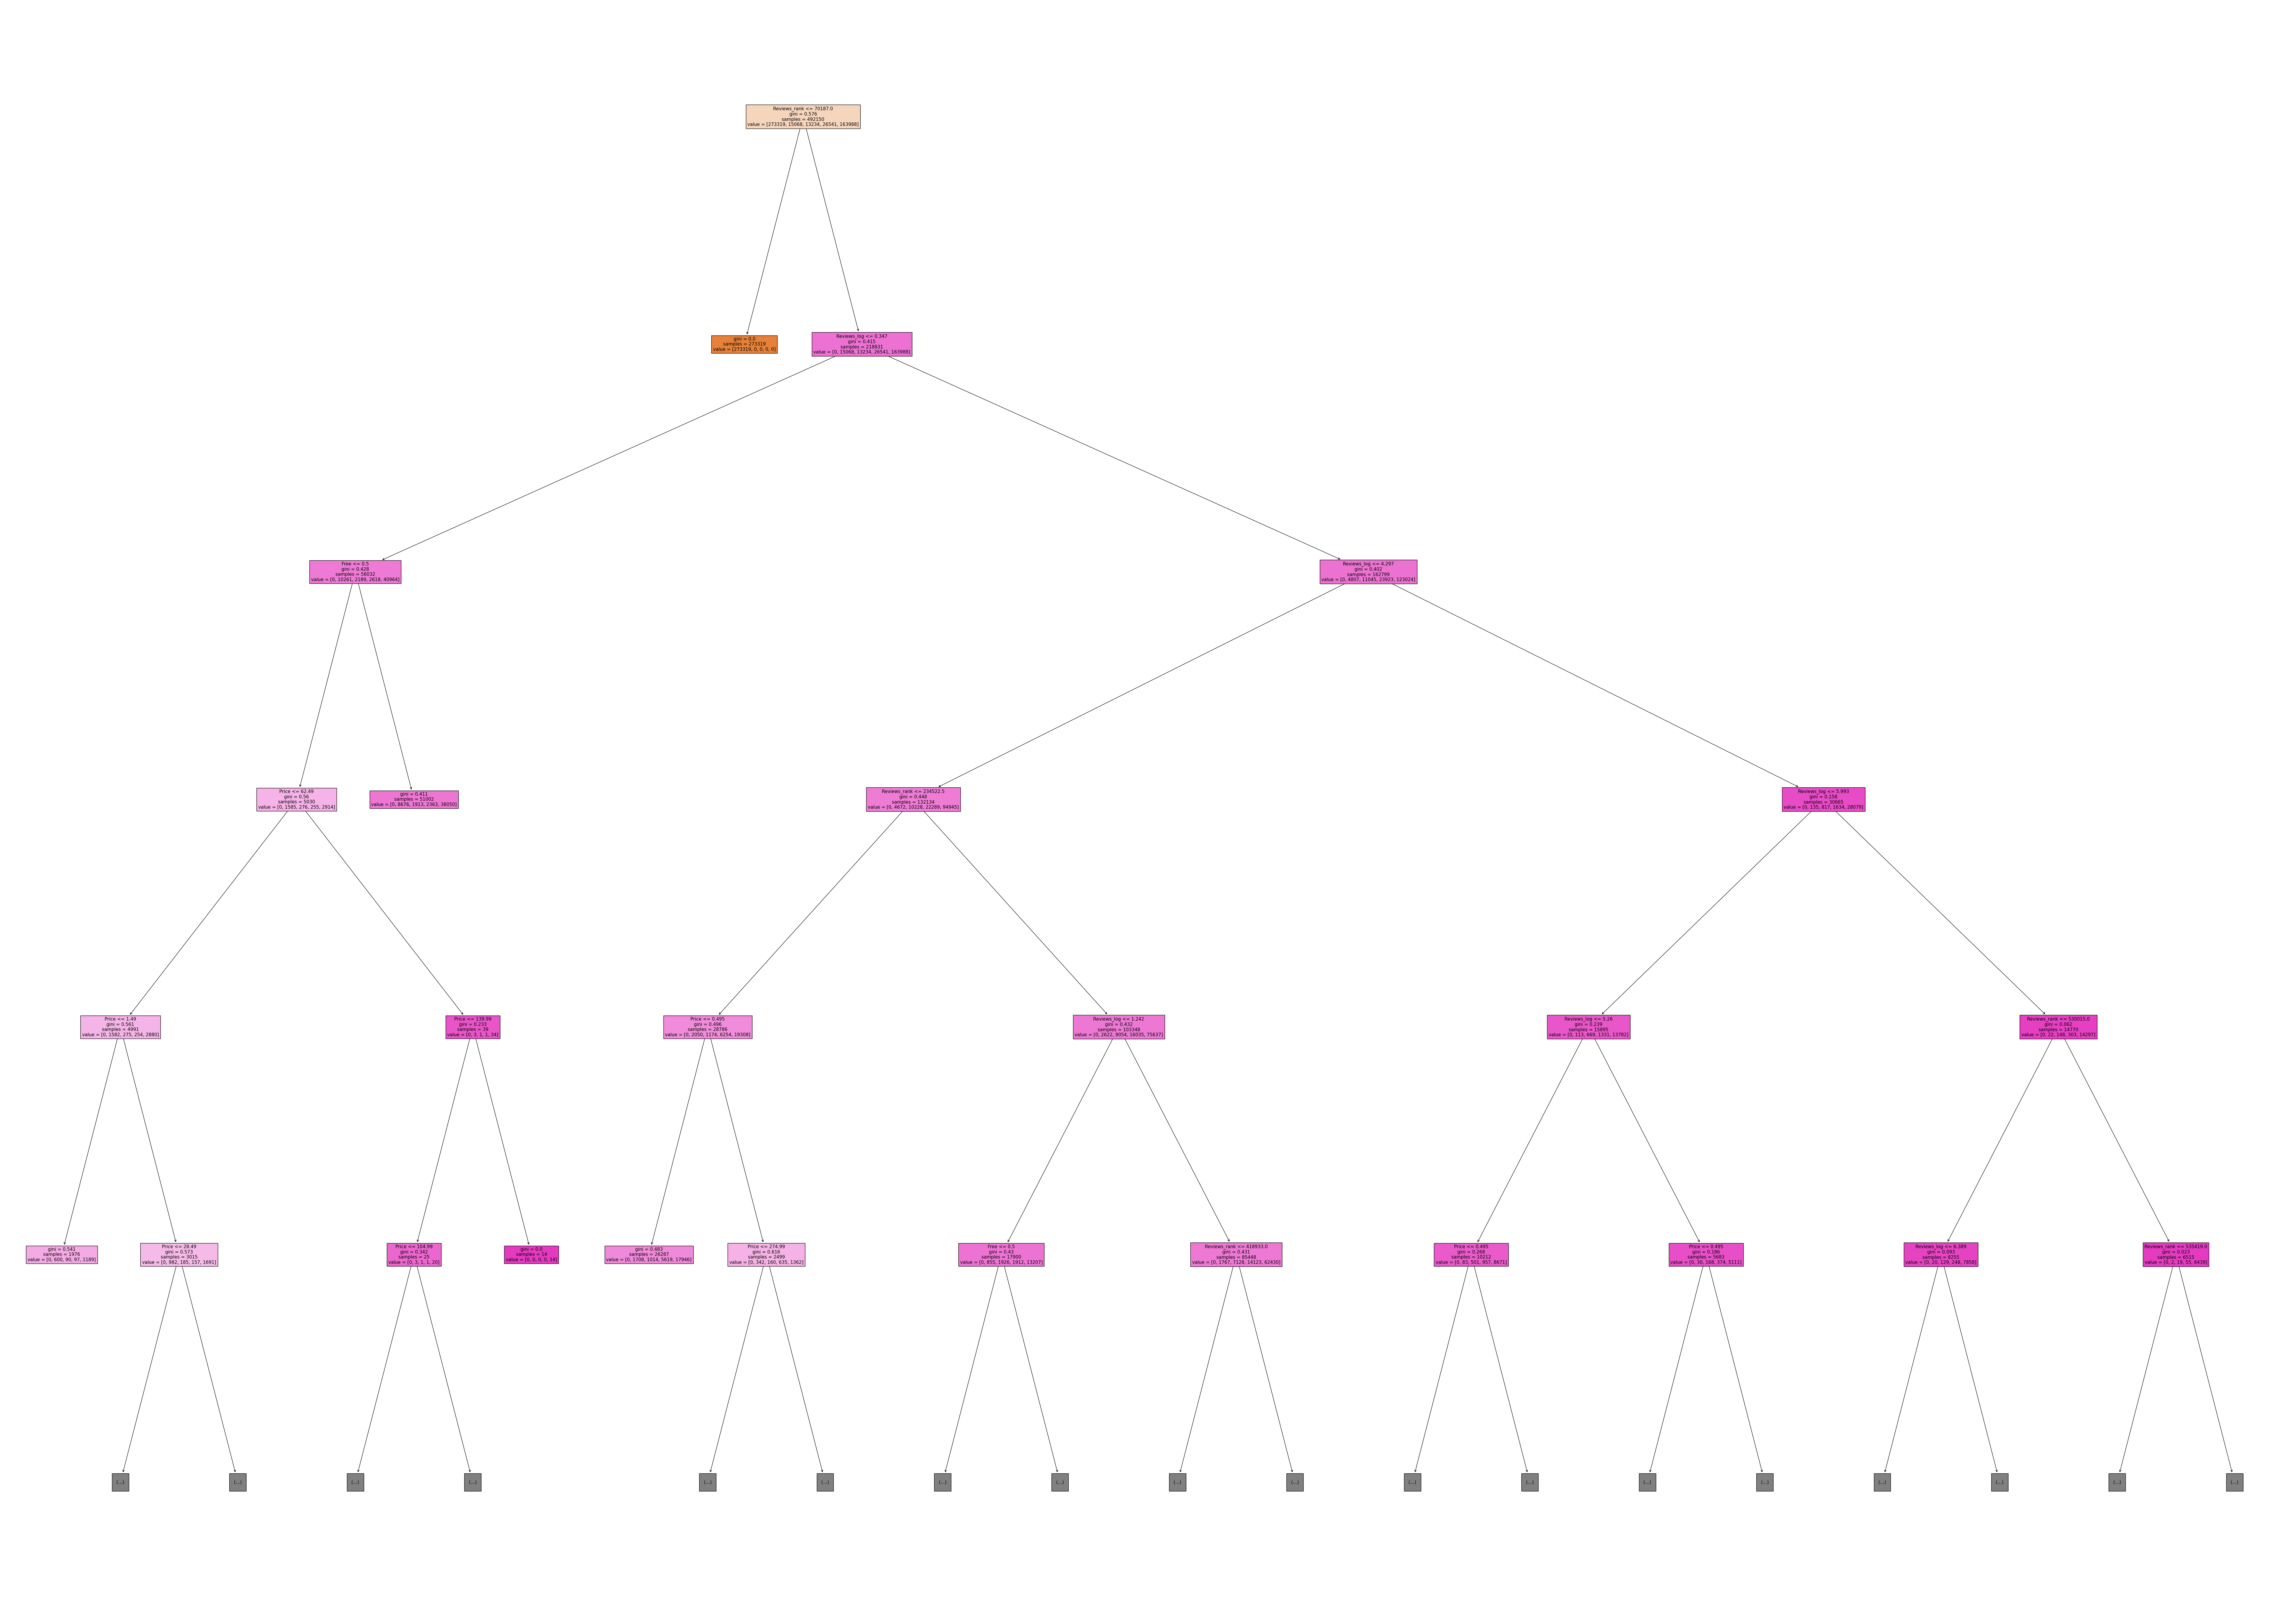

In [326]:
from sklearn import tree
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(100,70))
tree.plot_tree(dt, feature_names=dt.feature_names_in_, filled=True, fontsize=11, ax=ax, max_depth=5)
plt.show()

# App Store

In [327]:
AppStore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230376 entries, 0 to 1230375
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype              
---  ------               --------------    -----              
 0   App_Id               1230376 non-null  object             
 1   App_Name             1230375 non-null  object             
 2   AppStore_Url         1230376 non-null  object             
 3   Primary_Genre        1230376 non-null  category           
 4   Content_Rating       1230376 non-null  category           
 5   Size_Bytes           1230152 non-null  float64            
 6   Released             1230376 non-null  datetime64[ns, UTC]
 7   Updated              1230376 non-null  datetime64[ns, UTC]
 8   Price                1230376 non-null  float64            
 9   Free                 1230376 non-null  bool               
 10  DeveloperId          1230376 non-null  int64              
 11  Developer            1230376 non-null  object     

In [328]:
from sklearn.model_selection import train_test_split
train_app, vt_app = train_test_split(AppStore, test_size=0.6)
valid_app, test_app = train_test_split(vt_app, test_size=0.5)
del vt_app
main_app = pandas.concat([train_app, valid_app])

In [329]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

### OLS

In [330]:
# simple OLS on multiple inputs
ols_model_results = pandas.DataFrame(columns=['variable','coef','R-sqr','adj R-sqr','AIC','LLF'])
for t in train_app.describe().columns:
    res = smf.ols(f'Average_User_Rating ~ {t}', data=train_app).fit()
    ols_model_results = ols_model_results.append(dict(zip(['variable','coef','R-sqr','adj R-sqr','AIC','LLF'], [t, res.params[1],res.rsquared, res.rsquared_adj, res.aic, res.llf])), ignore_index=True)

ols_model_results.sort_values('R-sqr')

variable                 coef                R-sqr  \
1                Price              -0.0036               0.0001   
4              Reviews               0.0000               0.0004   
0           Size_Bytes               0.0000               0.0024   
5       Size_Megabytes               0.0005               0.0024   
2          DeveloperId              -0.0000               0.0149   
6       Size_Bytes_log               0.2338               0.0168   
7   Size_Megabytes_log               0.2338               0.0168   
8          Reviews_log               0.6725               0.3089   
9         Reviews_rank               0.0000               0.6662   
3  Average_User_Rating               1.0000               1.0000   

             adj R-sqr                  AIC                  LLF  
1               0.0001       2,151,835.2605      -1,075,915.6303  
4               0.0004       2,151,695.0486      -1,075,845.5243  
0               0.0024       2,150,335.5955      -1,075,165.7977  
5               0.0024       2,150,335.5955      -1,075,165.7977  
2               0.0149       2,144,517.0923      -1,072,256.5462  
6               0.0168       2,143,193.2434      -1,071,594.6217  
7               0.0168       2,143,193.2434      -1,071,594.6217  
8               0.3089       1,970,023.5269        -985,009.7634  
9               0.6662       1,611,857.3415        -805,926.6707  
3               1.0000     -28,131,261.5522      14,065,632.7761

In [331]:
res = smf.ols('Average_User_Rating ~ Reviews_rank', data=train_app).fit()
print(res.summary())
# R-squared
print('R-squared on validation set')
print(1 - numpy.sum((res.predict(valid_app['Reviews_rank']).to_numpy() - valid_app['Average_User_Rating'])**2) / numpy.sum((valid_app['Average_User_Rating'].to_numpy(dtype='float64') - numpy.mean(valid_app['Average_User_Rating'].to_numpy(dtype='float64')))**2))

                             OLS Regression Results                            
Dep. Variable:     Average_User_Rating   R-squared:                       0.666
Model:                             OLS   Adj. R-squared:                  0.666
Method:                  Least Squares   F-statistic:                 9.824e+05
Date:                 Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                         21:51:11   Log-Likelihood:            -8.0593e+05
No. Observations:               492150   AIC:                         1.612e+06
Df Residuals:                   492148   BIC:                         1.612e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4303      0.002    

In [332]:
res = smf.ols('Average_User_Rating ~ Reviews_rank', data=main_app).fit()
print(res.summary())
# R-squared
print('R-squared on validation set')
print(1 - numpy.sum((res.predict(test_app['Reviews_rank']).to_numpy() - test_app['Average_User_Rating'])**2) / numpy.sum((test_app['Average_User_Rating'].to_numpy(dtype='float64') - numpy.mean(test_app['Average_User_Rating'].to_numpy(dtype='float64')))**2))

                             OLS Regression Results                            
Dep. Variable:     Average_User_Rating   R-squared:                       0.666
Model:                             OLS   Adj. R-squared:                  0.666
Method:                  Least Squares   F-statistic:                 1.715e+06
Date:                 Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                         21:51:12   Log-Likelihood:            -1.4115e+06
No. Observations:               861263   AIC:                         2.823e+06
Df Residuals:                   861261   BIC:                         2.823e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4321      0.002    

======================================================================================================

In [333]:
res = smf.ols('Average_User_Rating ~ C(Primary_Genre)', data=train_app).fit()
print(res.summary())
# R-squared
print('R-squared on validation set')
print(1 - numpy.sum((res.predict(valid_app['Primary_Genre']).to_numpy() - valid_app['Average_User_Rating'])**2) / numpy.sum((valid_app['Average_User_Rating'].to_numpy(dtype='float64') - numpy.mean(valid_app['Average_User_Rating'].to_numpy(dtype='float64')))**2))

                             OLS Regression Results                            
Dep. Variable:     Average_User_Rating   R-squared:                       0.044
Model:                             OLS   Adj. R-squared:                  0.044
Method:                  Least Squares   F-statistic:                     908.6
Date:                 Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                         21:51:14   Log-Likelihood:            -1.0648e+06
No. Observations:               492150   AIC:                         2.130e+06
Df Residuals:                   492124   BIC:                         2.130e+06
Df Model:                           25                                         
Covariance Type:             nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [334]:
res = smf.ols('Average_User_Rating ~ Reviews_log + C(Primary_Genre)', data=train_app).fit()
print(res.summary())
# R-squared
print('R-squared on validation set')
print(1 - numpy.sum((res.predict(valid_app[['Reviews_log','Primary_Genre']]).to_numpy() - valid_app['Average_User_Rating'])**2) / numpy.sum((valid_app['Average_User_Rating'].to_numpy(dtype='float64') - numpy.mean(valid_app['Average_User_Rating'].to_numpy(dtype='float64')))**2))

                             OLS Regression Results                            
Dep. Variable:     Average_User_Rating   R-squared:                       0.319
Model:                             OLS   Adj. R-squared:                  0.319
Method:                  Least Squares   F-statistic:                     8861.
Date:                 Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                         21:51:18   Log-Likelihood:            -9.8145e+05
No. Observations:               492150   AIC:                         1.963e+06
Df Residuals:                   492123   BIC:                         1.963e+06
Df Model:                           26                                         
Covariance Type:             nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [335]:
res = smf.ols('Average_User_Rating ~ Price:Free + Reviews_log + Size_Megabytes_log', data=train_app).fit()
print(res.summary())
print('R-squared on validation set')
print(1 - numpy.sum((res.predict(valid_app[['Price','Free','Reviews_log', 'Size_Megabytes_log']]).to_numpy() - valid_app['Average_User_Rating'])**2) / numpy.sum((valid_app['Average_User_Rating'].to_numpy(dtype='float64') - numpy.mean(valid_app['Average_User_Rating'].to_numpy(dtype='float64')))**2))

                             OLS Regression Results                            
Dep. Variable:     Average_User_Rating   R-squared:                       0.310
Model:                             OLS   Adj. R-squared:                  0.310
Method:                  Least Squares   F-statistic:                 7.355e+04
Date:                 Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                         21:51:19   Log-Likelihood:            -9.8461e+05
No. Observations:               492067   AIC:                         1.969e+06
Df Residuals:                   492063   BIC:                         1.969e+06
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0

### Logistic regression

In [336]:
AppStore['isRated'] = 0
AppStore.loc[AppStore['Average_User_Rating']>0,'isRated'] = 1

In [337]:
from sklearn.model_selection import train_test_split
train_app, vt_app = train_test_split(AppStore, test_size=0.6)
valid_app, test_app = train_test_split(vt_app, test_size=0.5)
del vt_app
main_app = pandas.concat([train_app, valid_app])

In [338]:
res = smf.logit('isRated ~ Reviews_log', data=train_app).fit()
print(res.summary())
print('Confusion matrix:')
cross = pandas.crosstab(res.predict(valid_app['Reviews_log']).apply(lambda x: 1 if x>=0.5 else 0), valid_app['isRated'], normalize=True)
print(cross)
print(f'Accuracy = {cross.loc[1,1] + cross.loc[0,0]}')

         Current function value: 0.305250
         Iterations: 35


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                isRated   No. Observations:               492150
Model:                          Logit   Df Residuals:                   492148
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5557
Time:                        21:51:23   Log-Likelihood:            -1.5023e+05
converged:                      False   LL-Null:                   -3.3809e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.5851      0.005   -341.806      0.000      -1.594      -1.576
Reviews_log    51.2140   2.01e+05      0.000      1.000   -3.95e+05    3.95e+05

Possibly complete quasi-separation: A fraction 

In [339]:
res = smf.logit('isRated ~ Reviews_log + C(Primary_Genre)', data=train_app).fit()
print(res.summary())
print('Confusion matrix:')
cross = pandas.crosstab(res.predict(valid_app[['Reviews_log', 'Primary_Genre']]).apply(lambda x: 1 if x>=0.5 else 0), valid_app['isRated'], normalize=True)
print(cross)
print(f'Accuracy = {cross.loc[1,1] + cross.loc[0,0]}')

         Current function value: 0.299315
         Iterations: 35


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                isRated   No. Observations:               492150
Model:                          Logit   Df Residuals:                   492123
Method:                           MLE   Df Model:                           26
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5643
Time:                        21:51:39   Log-Likelihood:            -1.4731e+05
converged:                      False   LL-Null:                   -3.3809e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -1.2106      0.045    -26.796      0.000      -1.299      -1.122
C(Primary_Genre)[T.Business]       

In [340]:
train_app.columns

Index(['App_Id', 'App_Name', 'AppStore_Url', 'Primary_Genre', 'Content_Rating',
       'Size_Bytes', 'Released', 'Updated', 'Price', 'Free', 'DeveloperId',
       'Developer', 'Average_User_Rating', 'Reviews', 'isMissingPrice',
       'Size_Megabytes', 'Size_Bytes_log', 'Size_Megabytes_log', 'Reviews_log',
       'Reviews_rank', 'isRated'],
      dtype='object')

In [341]:
def to_cat(val):
    if val == 0: return '0'
    if (val>0) & (val<1.5): return '1'
    if (val>=1.5) & (val<2.5): return '2'
    if (val>=2.5) & (val<3.5): return '3'
    if (val>=3.5) & (val<4.5): return '4-5'
    if (val>=4.5): return '4-5'

train_app['Rating_categorical'] = train_app['Average_User_Rating'].apply(to_cat).astype('category')
valid_app['Rating_categorical'] = valid_app['Average_User_Rating'].apply(to_cat).astype('category')
test_app['Rating_categorical'] = test_app['Average_User_Rating'].apply(to_cat).astype('category')
main_app = pandas.concat([train_app, valid_app])

In [342]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=10)
dt = dt.fit(train_app[['Price', 'Free','Reviews_log', 'Reviews_rank']], train_app['Rating_categorical'])
print(dt.get_params())
cross = pandas.concat([valid_app['Rating_categorical'], pandas.Series(dt.predict(valid_app[['Price', 'Free','Reviews_log', 'Reviews_rank']]),index= valid_app.index,name='prediction')], axis=1)
pandas.crosstab(cross['Rating_categorical'], cross['prediction'], normalize=True)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


prediction                            0                    1  \
Rating_categorical                                             
0                                0.5575               0.0000   
1                                0.0000               0.0000   
2                                0.0000               0.0000   
3                                0.0000               0.0000   
4-5                              0.0000               0.0000   

prediction                            2                    3  \
Rating_categorical                                             
0                                0.0000               0.0000   
1                                0.0000               0.0000   
2                                0.0000               0.0000   
3                                0.0000               0.0000   
4-5                              0.0000               0.0001   

prediction                          4-5  
Rating_categorical                       
0                                0.0000  
1                                0.0304  
2                                0.0266  
3                                0.0536  
4-5                              0.3317

In [343]:
pandas.crosstab(cross['Rating_categorical'], cross['prediction'], normalize=True).to_excel('model_results.xlsx')

In [344]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

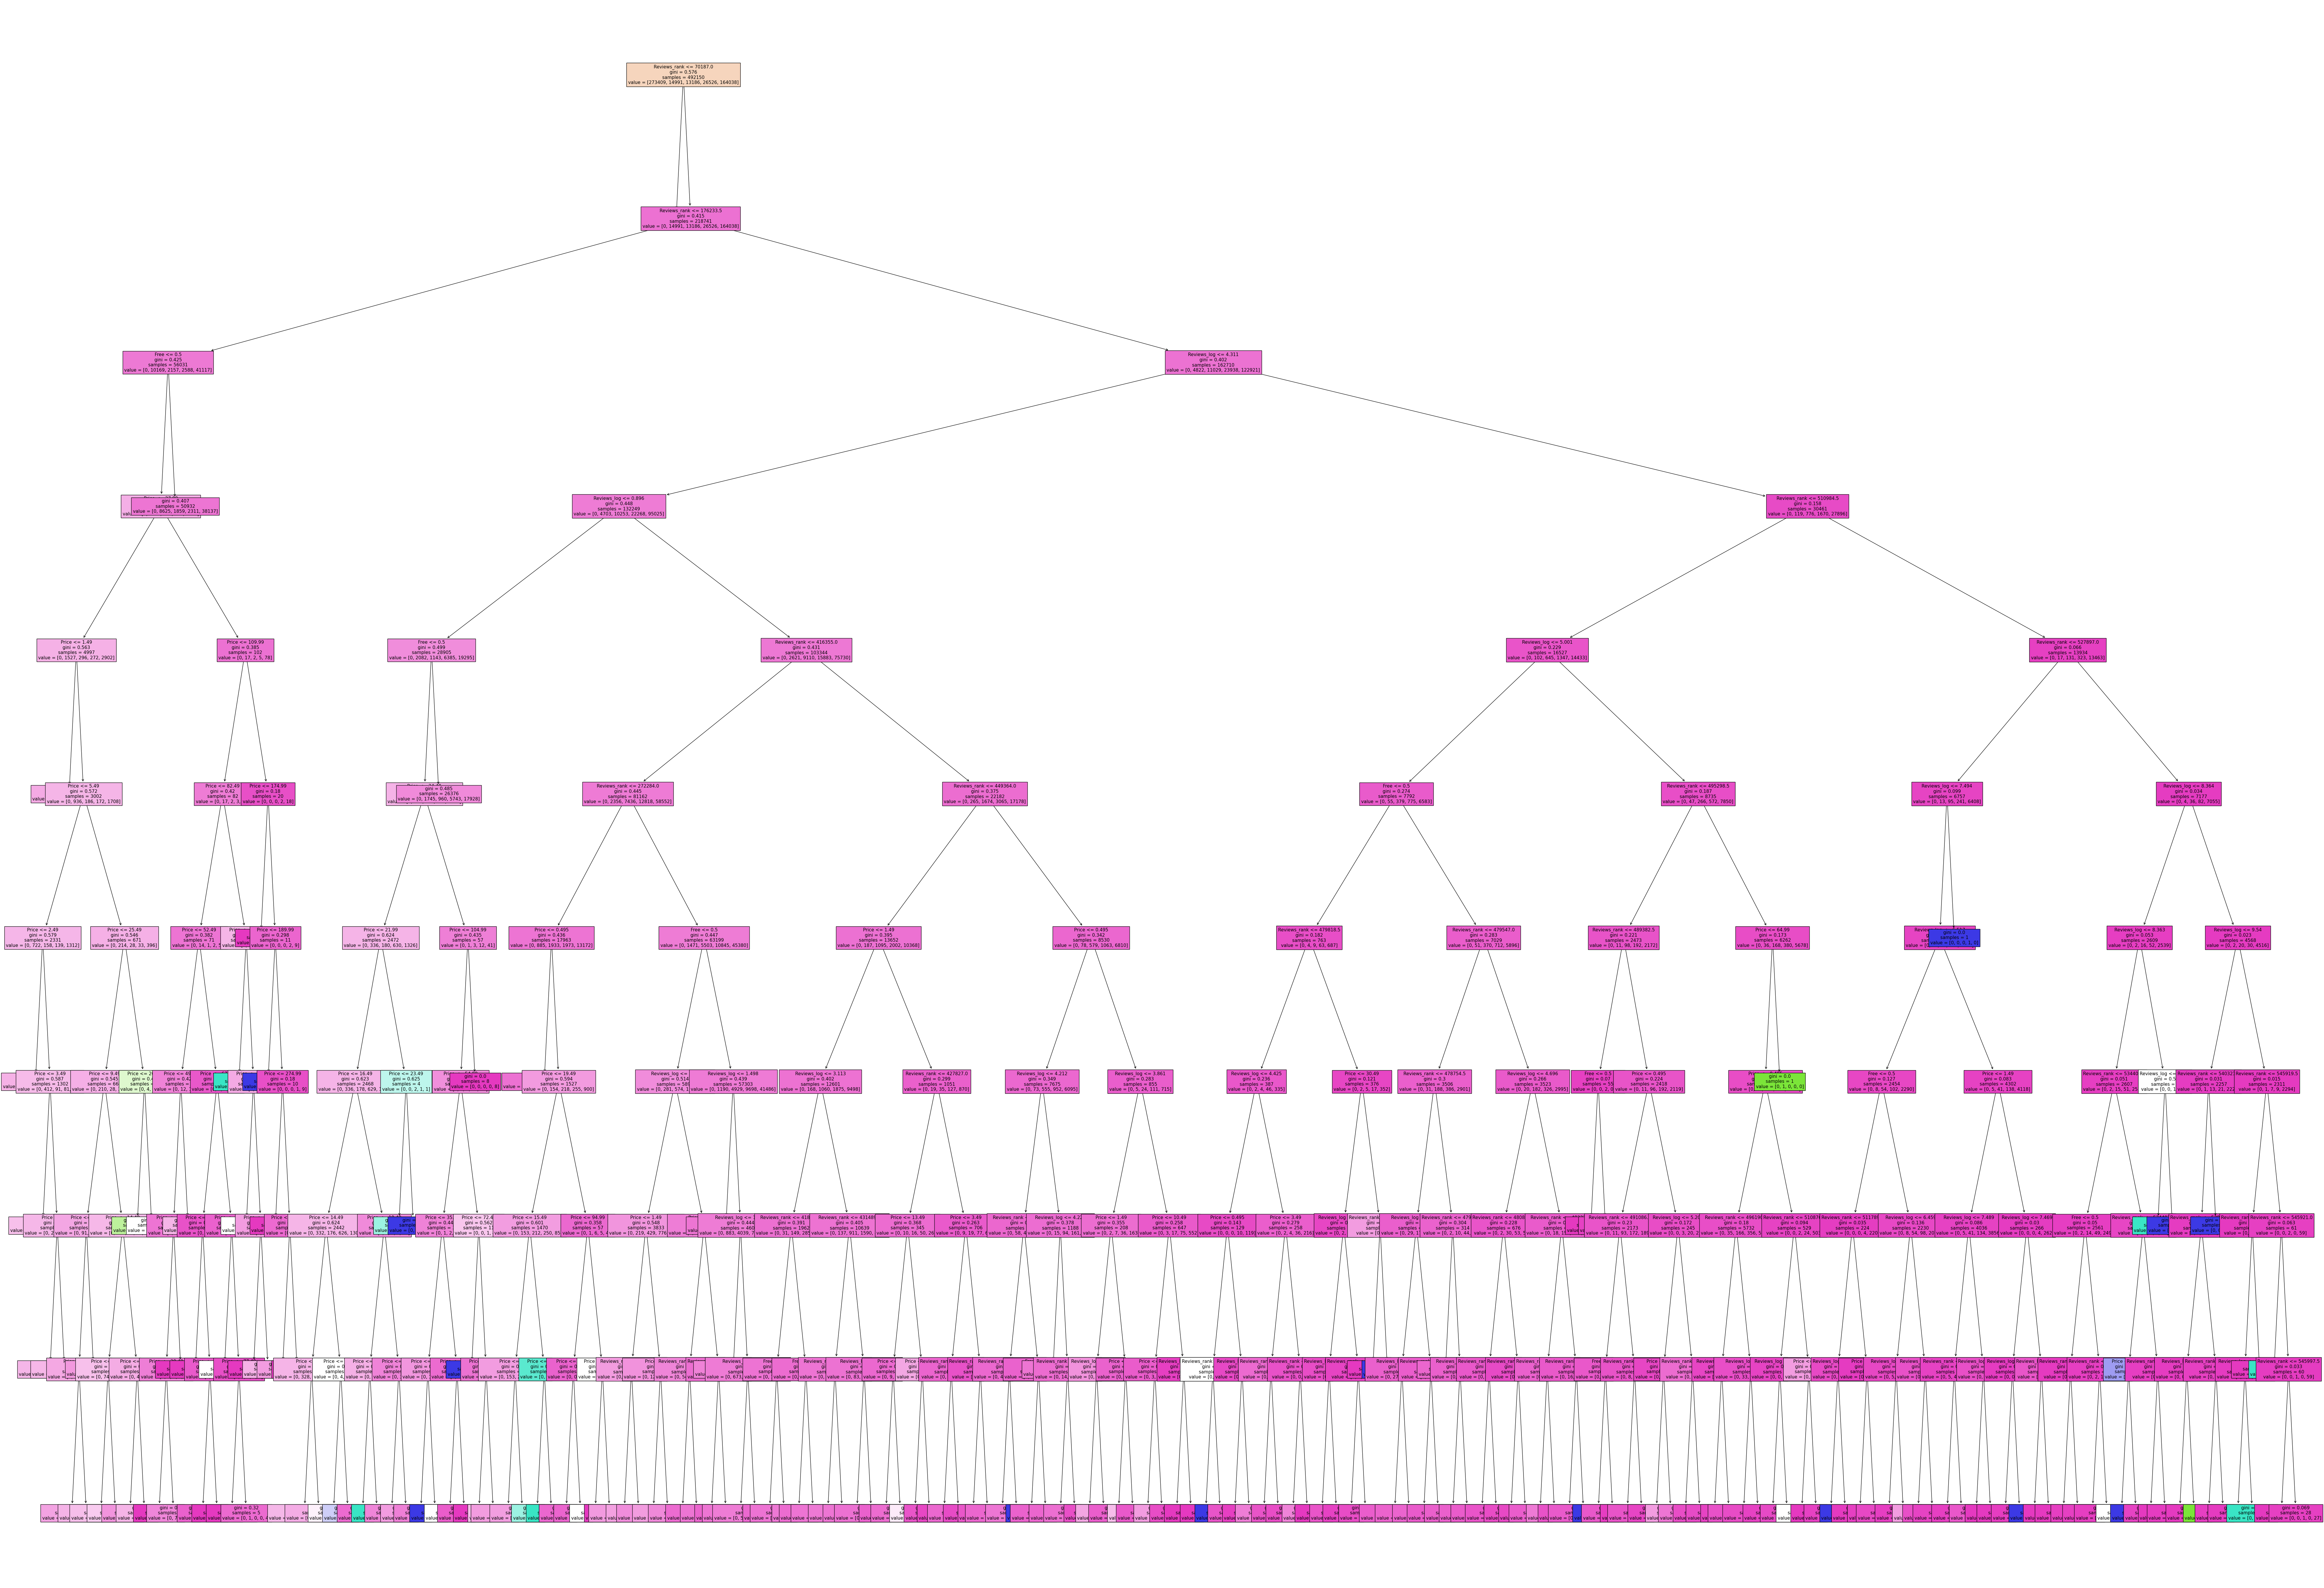

In [345]:
from sklearn import tree
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(100,70))
tree.plot_tree(dt, feature_names=dt.feature_names_in_, filled=True, fontsize=11, ax=ax)
plt.show()